# Deep Learning Model
We are aiming to predict the Lip_norm parameter based on the binary positions and full embedding of a peptide.

## Dataset preparation

### Read and prepare embeddings
Read generated embeddings from the pkl file, that was generated in notebook 2.

In [1]:
import pickle
import pandas as pd
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_and_process_embedding(file_path):
    # Function to process data from file
    with open(file_path, 'rb') as file:
        try:
            segment_count = 0  # Initialize segment counter
            while True:
                # Load each segment of data
                data = pickle.load(file)
                embeddings = pd.DataFrame(data['embeddings'])
                binary_positions = pd.DataFrame(data['Padded_Binary_Positions'])
                y_values = pd.DataFrame(data['Log2FC(LiP_norm)'])

                segment_count += 1  # Increment segment counter
                print(f"Processing segment {segment_count} from {file_path}")

                yield (embeddings, binary_positions, y_values)
        except EOFError:
            # End of file reached
            pass

embedding_files = [
    'data/dataset_1.pkl',
    'data/dataset_2.pkl',
    'data/dataset_3.pkl',
]

embeddings_tensors = []
binary_positions_tensors = []
y_tensors = []

for file_path in embedding_files:
    print(f"Processing {file_path}")
    for embeddings_segment, binary_positions_segment, y_segment in load_and_process_embedding(file_path):
        # Convert DataFrames to tensors and send to device
        embeddings_tensor = torch.tensor(np.array(embeddings_segment.values.tolist(), dtype=np.float16).reshape(-1, 1000, 1280), device=device)
        binary_positions_tensor = torch.tensor(np.array(binary_positions_segment.values.tolist(), dtype=np.float16).reshape(-1, 1000), device=device)
        y_tensor = torch.tensor(np.array(y_segment.values.squeeze().tolist(), dtype=np.float16), device=device)

        embeddings_tensors.append(embeddings_tensor)
        binary_positions_tensors.append(binary_positions_tensor)
        y_tensors.append(y_tensor)

final_embeddings_tensor = torch.cat(embeddings_tensors, dim=0)
final_binary_positions_tensor = torch.cat(binary_positions_tensors, dim=0)
final_y_tensor = torch.cat(y_tensors, dim=0)

Processing data/dataset_1.pkl
Processing segment 1 from data/dataset_1.pkl
Processing data/dataset_2.pkl
Processing segment 1 from data/dataset_2.pkl
Processing data/dataset_3.pkl
Processing segment 1 from data/dataset_3.pkl


In [2]:
print(final_embeddings_tensor.shape)
print(final_binary_positions_tensor.shape)
print(final_y_tensor.shape)

torch.Size([4818, 1000, 1280])
torch.Size([4818, 1000])
torch.Size([4818])


In [3]:
min_y = final_y_tensor.min()
max_y = final_y_tensor.max()

final_y_tensor = (final_y_tensor - min_y) / (max_y - min_y)
print(final_y_tensor.shape)

torch.Size([4818])


In [4]:
final_embeddings_tensor

tensor([[[ 0.0538,  0.0933, -0.1127,  ..., -0.0775, -0.0900,  0.0501],
         [ 0.0823,  0.2333,  0.0698,  ..., -0.1198,  0.0682, -0.1095],
         [ 0.1109,  0.0232, -0.2323,  ..., -0.1752,  0.0599, -0.0380],
         ...,
         [ 0.0111,  0.0469,  0.1438,  ..., -0.2695, -0.1698,  0.1092],
         [ 0.0173,  0.0014,  0.2148,  ..., -0.2423, -0.1848,  0.0827],
         [ 0.0306,  0.0261,  0.1796,  ..., -0.1948, -0.1263,  0.0622]],

        [[ 0.0044, -0.0960, -0.0081,  ...,  0.2495, -0.0632,  0.0994],
         [ 0.2922, -0.1602,  0.1565,  ..., -0.0442,  0.3345, -0.1827],
         [ 0.0203, -0.0525,  0.0384,  ...,  0.1079,  0.2402, -0.0123],
         ...,
         [-0.0648, -0.0485,  0.0245,  ...,  0.0252, -0.0164, -0.0882],
         [-0.0555, -0.0442,  0.0016,  ..., -0.0331, -0.0100, -0.0816],
         [-0.0238, -0.0393,  0.0153,  ..., -0.0508,  0.0820, -0.0781]],

        [[ 0.0044, -0.0960, -0.0081,  ...,  0.2495, -0.0632,  0.0994],
         [ 0.2922, -0.1602,  0.1565,  ..., -0

In [5]:
final_embeddings_tensor.shape

torch.Size([4818, 1000, 1280])

In [7]:
y_series = pd.Series(final_y_tensor.cpu())

# Get a statistical summary
summary = y_series.describe()
print(summary)

count    4818.000000
mean        0.569824
std         0.032806
min         0.000000
25%         0.550781
50%         0.571777
75%         0.586914
max         1.000000
dtype: float64


## Model Training
Now that we have both input and target data, we can create our model.

In [8]:
import torch

print(torch.__version__)
print(device)

1.13.1+cu116
cuda


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
from torch.utils.data import TensorDataset, DataLoader, random_split, Dataset
from torch.cuda.amp import GradScaler, autocast

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(16)

# Data setup
class PeptideDataset(Dataset):
    def __init__(self, embeddings, position, y):
        self.embeddings = torch.tensor(embeddings, dtype = torch.float16)
        self.position = torch.tensor(position, dtype = torch.int64)
        self.y = torch.tensor(y, dtype = torch.float16)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        x = {"embeddings":self.embeddings[index],
             "position":self.position[index]}
        y = self.y[index]
        return x, y

############################################# If shuffle true ##############################################
dataset = PeptideDataset(final_embeddings_tensor, final_binary_positions_tensor, final_y_tensor)

train_size = int(0.6 * len(dataset))
val_size = int(0.3 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size,test_size])

############################################################################################################

# train_dataset = PeptideDataset(train_embeddings, train_positions, train_y)
# val_dataset = PeptideDataset(val_embeddings, val_positions, val_y)
# test_dataset = PeptideDataset(test_embeddings, test_positions, test_y)


/data/nasif12/home_if12/l_schewinski/.conda/envs/l-schewinski-tp-2/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/data/nasif12/home_if12/l_schewinski/.conda/envs/l-schewinski-tp-2/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/data/nasif12/home_if12/l_schewinski/.conda/envs/l-schewinski-tp-2/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app

In [112]:
batch_size = 24

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model definition
class PeptideRegressor(nn.Module):
    def __init__(self, input_dim, num_heads, dropout_rate):
        super(PeptideRegressor, self).__init__()

        self.dropout = nn.Dropout(0.4)
        self.fc_embed = torch.nn.Linear(1280, 256)

        self.pos_embed = nn.Embedding(2, 1280)
        
        self.seq_pos_embed = nn.Embedding(1000, 1280)
        self.pept_pos_embed = nn.Embedding(2, 1280)
        
        self.norm = nn.LayerNorm(input_dim)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256, 
            nhead=num_heads, 
            dropout=dropout_rate
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256, 1)

    def forward(self, x):
        positions = x["position"]
        x = x["embeddings"] + self.seq_pos_embed(torch.arange(x["position"].size(1), device=device)) + self.pept_pos_embed(x["position"])
        x = x.permute(1, 0, 2)
        
        embed = self.fc_embed(x)
        # embed = self.dropout(embed)
        
        transformer_output = self.transformer_encoder(embed)
        transformer_output = transformer_output.permute(1, 2, 0)
        
        mask = positions == 1
        mask = mask.unsqueeze(1)
        peptide_embeddings = transformer_output * mask.float()
        pooled = torch.sum(peptide_embeddings, dim=-1)/torch.sum(positions==1,dim=-1).unsqueeze(1)
        
        
        output = self.fc(pooled)
        return output

Epoch 1, Train Loss: 0.04665524885058403
Epoch 2, Train Loss: 51.37748336791992
Epoch 3, Train Loss: 15.269622802734375
Epoch 4, Train Loss: 0.38135993480682373
Epoch 5, Train Loss: 2.183406352996826
Epoch 6, Train Loss: 2.9372901916503906
Epoch 7, Train Loss: 1.2915163040161133
Epoch 8, Train Loss: 0.048870742321014404
Epoch 9, Train Loss: 0.4666246175765991
Epoch 10, Train Loss: 0.8137192726135254
Epoch 11, Train Loss: 0.4933633804321289
Epoch 12, Train Loss: 0.12600207328796387
Epoch 13, Train Loss: 0.0007491211290471256
Epoch 14, Train Loss: 0.08022856712341309
Epoch 15, Train Loss: 0.21775728464126587
Epoch 16, Train Loss: 0.26772841811180115
Epoch 17, Train Loss: 0.2295815348625183
Epoch 18, Train Loss: 0.13292056322097778
Epoch 19, Train Loss: 0.04837816208600998
Epoch 20, Train Loss: 0.0037358428817242384
Epoch 21, Train Loss: 0.008576720952987671
Epoch 22, Train Loss: 0.04349803179502487
Epoch 23, Train Loss: 0.07438015192747116
Epoch 24, Train Loss: 0.08246713876724243
Epoch 

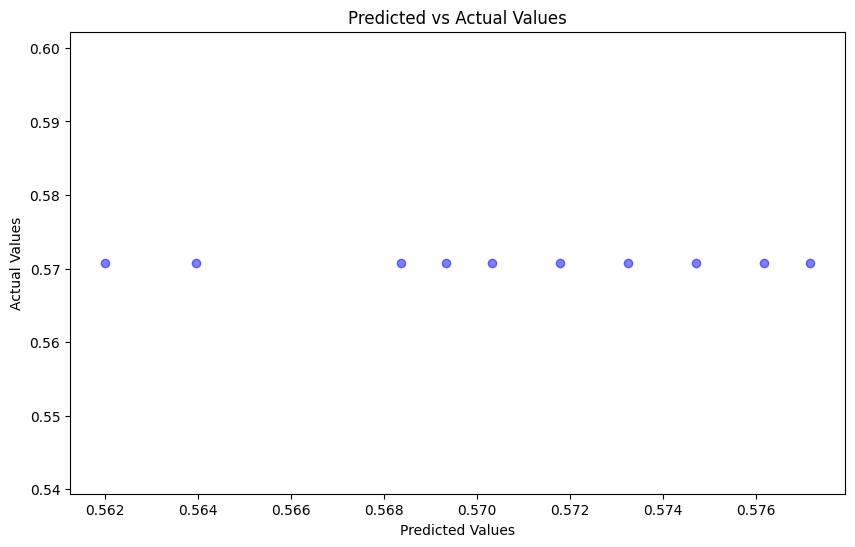

In [113]:
import matplotlib.pyplot as plt

model = PeptideRegressor(input_dim=1280, num_heads=4, dropout_rate=0.05)
model = model.to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

scaler = GradScaler()

# Training settings
n_epochs = 200
best_val_loss = float('inf')
train_losses_avg = []
val_losses_avg = []

single_batch_X, single_batch_y = next(iter(train_loader))
for k, v in single_batch_X.items():
    single_batch_X[k] = v.to(device, non_blocking=True)
single_batch_y = single_batch_y.to(device, non_blocking=True)

predictions = []
actuals = []

# Training loop using a single batch for overfitting check
for epoch in range(n_epochs):
    model.train()
    train_losses = []

    optimizer.zero_grad()

    with autocast():
        y_pred = model(single_batch_X)
        loss = loss_fn(y_pred, single_batch_y.unsqueeze(1))

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    train_loss_avg = sum(train_losses) / len(train_losses)

    mean_pred = y_pred.detach().cpu().numpy().mean()
    mean_actual = single_batch_y.detach().cpu().numpy().mean()
    predictions.append(mean_pred)
    actuals.append(mean_actual)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss_avg}')

predictions_plot = predictions[-10:]
actuals_plot = actuals[-10:]

print(actuals_plot)
print(predictions_plot)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(predictions_plot, actuals_plot, alpha=0.5, color='blue')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
ax.set_title('Predicted vs Actual Values')

plt.show()

In [149]:
model = PeptideRegressor(input_dim=1280, num_heads=4, dropout_rate=0.05)
model = model.to(device)

loss_fn = nn.MSELoss()
# loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.00003, weight_decay=1e-4)
# optimizer = optim.AdamW(model.parameters(), lr=0.0005)00003

scaler = GradScaler()

# Training settings
n_epochs = 20
best_val_loss = float('inf')
train_losses_avg = []
val_losses_avg = []

# Training loop
for epoch in range(n_epochs):
    model.train()
    train_losses = []
    for X_batch, y_batch in train_loader:
        for k, v in X_batch.items():
            X_batch[k] = v.to(device, non_blocking=True)
        y_batch = y_batch.to(device, non_blocking=True)

        optimizer.zero_grad()

        with autocast():
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch.unsqueeze(1))

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    train_losses_avg.append(sum(train_losses) / len(train_losses))
    print(f'Epoch {epoch+1}, Train Loss: {train_losses_avg[-1]}')

    model.eval()
    val_losses = []
    for X_batch, y_batch in val_loader:
        for k, v in X_batch.items():
            X_batch[k] = v.to(device, non_blocking=True)
        y_batch = y_batch.to(device, non_blocking=True)

        with torch.no_grad(), autocast():
            y_pred = model(X_batch)
            mse = loss_fn(y_pred, y_batch.unsqueeze(1))
            val_losses.append(mse.item())

    avg_val_loss = sum(val_losses) / len(val_losses)
    val_losses_avg.append(avg_val_loss)
    print(f'Epoch {epoch+1}, Val MSE: {avg_val_loss}')
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model = copy.deepcopy(model.state_dict())

torch.save({
    'model_state_dict': best_model,
}, 'best_peptide_model.pth')

Epoch 1, Train Loss: 0.027256933579698574
Epoch 1, Val MSE: 0.005752929482517428
Epoch 2, Train Loss: 0.00491445594609615
Epoch 2, Val MSE: 0.0037041789447491776
Epoch 3, Train Loss: 0.003420323724204228
Epoch 3, Val MSE: 0.0030640971094950055
Epoch 4, Train Loss: 0.002711625091446764
Epoch 4, Val MSE: 0.002533511223355461
Epoch 5, Train Loss: 0.0023278776519693248
Epoch 5, Val MSE: 0.00206441106274724
Epoch 6, Train Loss: 0.002072924459430058
Epoch 6, Val MSE: 0.0018323274705268932
Epoch 7, Train Loss: 0.001872910689350895
Epoch 7, Val MSE: 0.0017119756509496478
Epoch 8, Train Loss: 0.001747075379306589
Epoch 8, Val MSE: 0.00167435479205346
Epoch 9, Train Loss: 0.0016081537767544327
Epoch 9, Val MSE: 0.0017195777417939218
Epoch 10, Train Loss: 0.001547831592913948
Epoch 10, Val MSE: 0.0017689206746223643
Epoch 11, Train Loss: 0.001666131674712293
Epoch 11, Val MSE: 0.0014622159801770888
Epoch 12, Train Loss: 0.0014867810295531064
Epoch 12, Val MSE: 0.0015180503241488802
Epoch 13, Trai

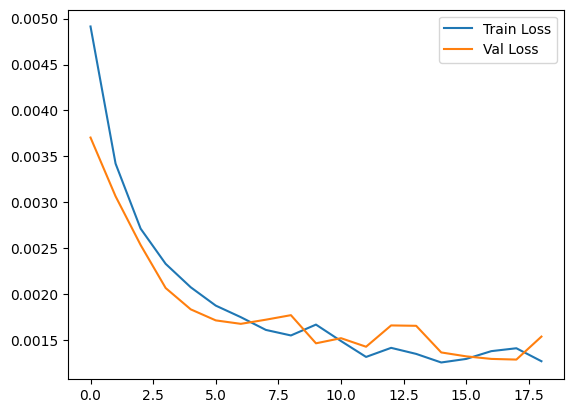

In [150]:
# # Visualize the training process
import matplotlib.pyplot as plt

plt.plot(train_losses_avg[1:], label='Train Loss')
plt.plot(val_losses_avg[1:], label='Val Loss')
plt.legend()
plt.show()


In [151]:
def model_summary(model):
    print("Model Summary:")
    print("{:<50} {:<30} {:<15} {:<15}".format("Layer Name", "Shape", "Parameters", "Trainable"))
    print("-" * 110)
    total_params = 0
    total_trainable_params = 0
    lm_params = 0
    lm_trainable_params = 0
    lm_layers = 0
    for name, parameter in model.named_parameters():
        param = parameter.numel()
        total_params += param
        # Check if the parameter is trainable
        trainable = parameter.requires_grad
        trainable_param = param if trainable else 0
        total_trainable_params += trainable_param
        print("{:<50} {:<30} {:<15} {:<15}".format(name, str(parameter.size()), param, trainable_param))
    print("-" * 110)
    print(f"Total Parameters: {total_params}")
    print(f"Trainable Parameters: {total_trainable_params}")

model_summary(model)

Model Summary:
Layer Name                                         Shape                          Parameters      Trainable      
--------------------------------------------------------------------------------------------------------------
fc_embed.weight                                    torch.Size([256, 1280])        327680          327680         
fc_embed.bias                                      torch.Size([256])              256             256            
pos_embed.weight                                   torch.Size([2, 1280])          2560            2560           
seq_pos_embed.weight                               torch.Size([1000, 1280])       1280000         1280000        
pept_pos_embed.weight                              torch.Size([2, 1280])          2560            2560           
norm.weight                                        torch.Size([1280])             1280            1280           
norm.bias                                          torch.Size([1280])       

In [154]:
model.load_state_dict(best_model)
model.eval()
test_losses = []
y_preds = []
y_actuals = []

for X_batch, y_batch in test_loader:
    for k, v in X_batch.items():
        X_batch[k] = v.to(device, non_blocking=True)
    y_batch = y_batch.to(device, non_blocking=True)
    
    with torch.no_grad(), autocast():
        y_pred = model(X_batch)
        mse = loss_fn(y_pred, y_batch.unsqueeze(1))
        
        y_preds.extend(y_pred.cpu().numpy())
        y_actuals.extend(y_batch.cpu().numpy())
        test_losses.append(mse.item())

avg_test_loss = sum(test_losses) / len(test_losses)
print(f'Test MSE: {avg_test_loss}')

Test MSE: 0.0030719886389782743


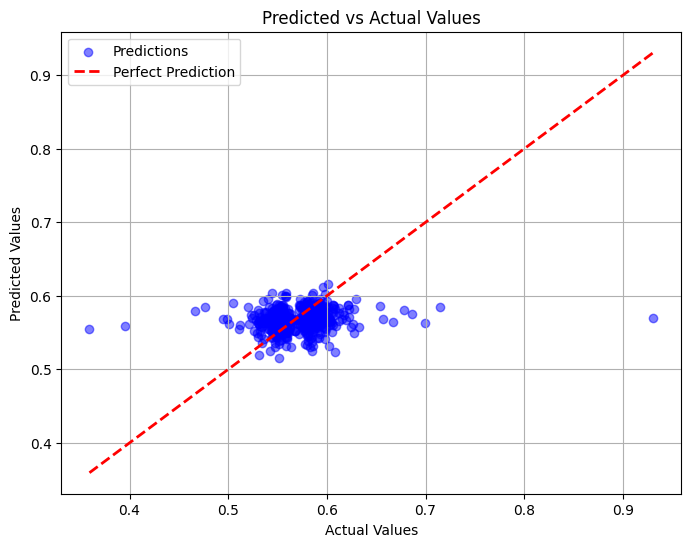

In [155]:
plt.figure(figsize=(8, 6))
plt.scatter(y_actuals, y_preds, alpha=0.5, color='blue', label='Predictions')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)

# Plotting the line of identity
max_val = max(max(y_actuals), max(y_preds))
min_val = min(min(y_actuals), min(y_preds))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

plt.legend()
plt.show()